# Dimensionality reduction
Dimension Reduction refers to the process of converting a set of data having vast dimensions into data with lesser dimensions ensuring that it conveys similar information concisely.

Techniques used here: Principal Component Analysis (also including Kernel PCA, Gaussian Kernel PCA) and Spectral Clustering.


PCA uses Singular Value Decomposition.<br>
Kernal PCA uses Eigenvector-Eigenvalue decomposition.<br>
Spectral Clustering uses K-Nearest Neighbors.<br>

# Clustering
Clustering is the task of grouping a set of objects in such a way that objects in the same group are more similar to each other than to those in other groups.

Technique used: K-means clustering

It clusters the low-dimension data from PCA or Spectral.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.io as sio
import math
import random

from IPython.display import display, Markdown, Math
from pprint import pprint

%matplotlib inline

In [2]:
dataset1 = sio.loadmat('dataset1')
dataset2 = sio.loadmat('dataset2')

Input data matrix, $Y \epsilon R^{D*N}$

In [3]:
Y_1 = np.matrix(dataset1['Y'])
Y_1.shape

(40, 200)

In [4]:
Y_2 = np.matrix(dataset2['Y'])
Y_2.shape

(40, 200)

In [5]:
def plot2D(x, y, title, x_label, y_label):
    
    fig, ax = plt.subplots(figsize=(12,8))  
    
    ax.scatter(x, y, s=50, marker='^', c='b')  
    
    ax.set_xlabel(x_label)  
    ax.set_ylabel(y_label) 
    plt.title(title)
    fig.tight_layout()
    plt.show()

# PCA 

In [6]:
def PCA(Y, N, d):
    # Calculating mean across all dimensions
    mu = Y.mean(axis=1)

    # Centering each Y ∈ R^D×N instance
    Y_std = Y - mu

    # Use the svd linear algebra function of NumPy to compute the SVD
    svd_u, svd_s, svd_v = np.linalg.svd(Y_std)
    
    # low-dimensional subspace U ∈ R^D×d
    U = svd_u[:, :d]
    
    # low-dimensional representation, X ∈ R^d×N
    X = np.dot(U.T, Y_std)
    
    return U, mu, X

# Kernel PCA

In [7]:
def KPCA(K, d):
    N = K.shape[0]
    
    # Centering the data
    temp = np.matlib.eye(N) - np.matlib.ones((N,N))/N
    K_center = temp @ K @ temp
    
    # Eigenvector-EigenValue Decomposition of K_center
    eigvals, eigvecs = np.linalg.eig(K_center)
    
    # Rescaling Eigenvectors s.t norm of eigvecs = 1/√eigvals
    W = eigvecs/np.sqrt(eigvals)
    
    # low-dimensional eigvecs
    W_center = W[:,:d]
    
    # low dimensional representation
    X = W_center.T @ K_center
    
    return X

# K-Means

In [8]:
def sse(x1, x2):
    """ returns the sum-squared-error between two points. """
    return np.linalg.norm(x1 - x2, 2, axis=0)

In [9]:
# Inputs: centroid locations, point
# Outputs: centroid index that is closest
def choose_cluster(centroids, x):
    centroid_dist = []
    # calculates distance of point x to every centroid
    for c in range(len(centroids)):
        centroid_dist.append(sse(x, centroids[c]))
        
    # returns the minimum distance centroid index
    return centroid_dist.index(min(centroid_dist))

In [10]:
# Inputs: 
#  data: data points (length=N)
#  k: no of clusters
#  r: no of random initializations
# 
# Outputs:
#  centroids: locations (length=K)
#  new_clusters: for each data point, index of associated cluster
#  iterations: count of iterations taken
#  total_sse: SSE of final clustering
def kmeans(data, k, r):
    data_points = data.shape[1]
    
    centroids = None
    clustering = []
    total_sse = np.inf
    iterations = 0
    
    # runs kmeans 'r' times with different random initialization, and picks one with min sse
    for init in range(r):
        # picking k initial centroids randomly
        initial_centroids = [data[:, i] for i in random.sample(range(data_points), k)]
        
        temp_centroids = initial_centroids[:]
        new_clusters = np.array([-1] * data.shape[1])
        temp_iterations = 0
        temp_total_sse = 0

        membership_change = False

        while True:
            # Expectation Step: Choosing the closest Cluster
            for i in range(data_points):
                point = data[:, i]

                c = choose_cluster(temp_centroids,point)
                if new_clusters[i] != c:
                    new_clusters[i] = c
                    membership_change = True

            # Maximization Step: Changing centroid locations to the center
            if membership_change == True:
                for c in range(len(temp_centroids)):
                    idx = [i for i, x in enumerate(new_clusters) if x == c]
                    temp_centroids[c] = np.mean(data[:, idx], axis=1)

                temp_iterations += 1
                membership_change = False
            else:
                break

        for i in range(data_points):
            point = data[:, i]
            temp_total_sse += sse(point, temp_centroids[new_clusters[i]])
            
        # If this initialization is best so far
        if temp_total_sse < total_sse:
            centroids = temp_centroids
            clustering = new_clusters
            iterations = temp_iterations
            total_sse = temp_total_sse

    return centroids, clustering, iterations, total_sse

In [11]:
def cluster_plot(centroids, data, clustering):
    for i,c in enumerate(centroids):
        points = [data[:, idx] for idx,c in enumerate(clustering) if c == i]
        plt.scatter([d[0].real for d in points], [d[1].real for d in points], label="{}".format(i))
        plt.plot(c[0].real, c[1].real, 'kx', mew=5, ms=10)
    plt.show()

## Analysing some features of a 40-dimensional space, Y (dataset1)

### i) 1st and 2nd features

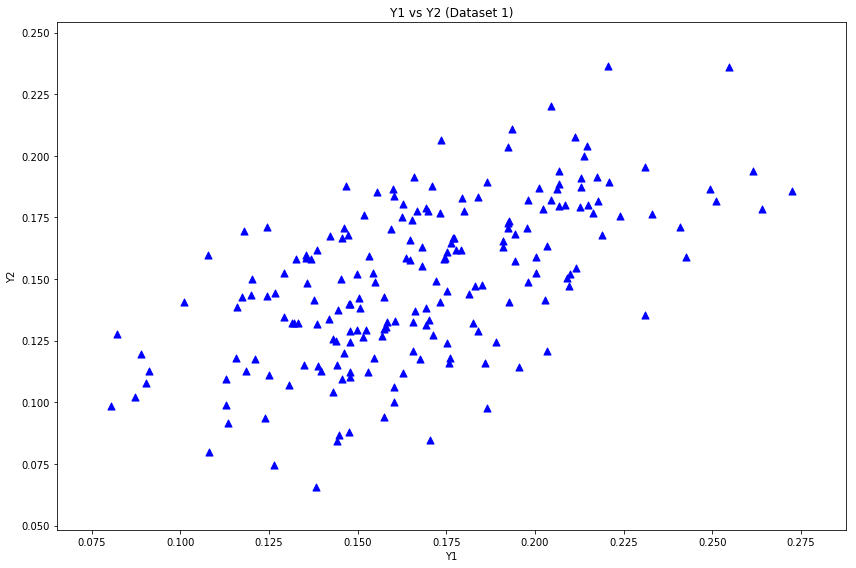

In [12]:
plot2D(list(Y_1[0, :].flat), list(Y_1[1, :].flat), 'Y1 vs Y2 (Dataset 1)', 'Y1', 'Y2')

The two features 'Y1' and 'Y2' are positively correlated.

### ii) 2nd and 3rd features

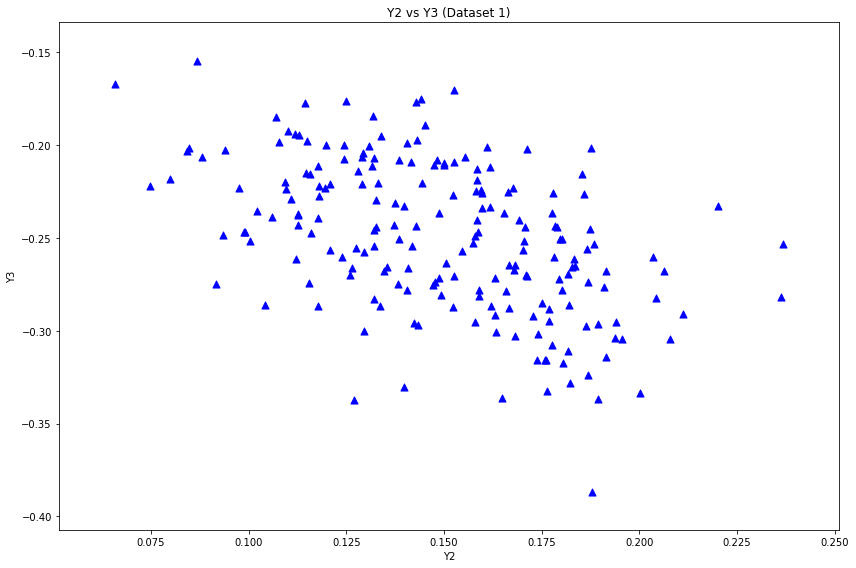

In [13]:
plot2D(list(Y_1[1,:].flat), list(Y_1[2,:].flat), 'Y2 vs Y3 (Dataset 1)', 'Y2', 'Y3')

The two features 'Y2' and 'Y3' are negatively correlated.

## PCA on dataset1 for low dimension, d=2

In [14]:
U_2d, mu, X1_2d = PCA(Y_1, Y_1.shape[1], 2)

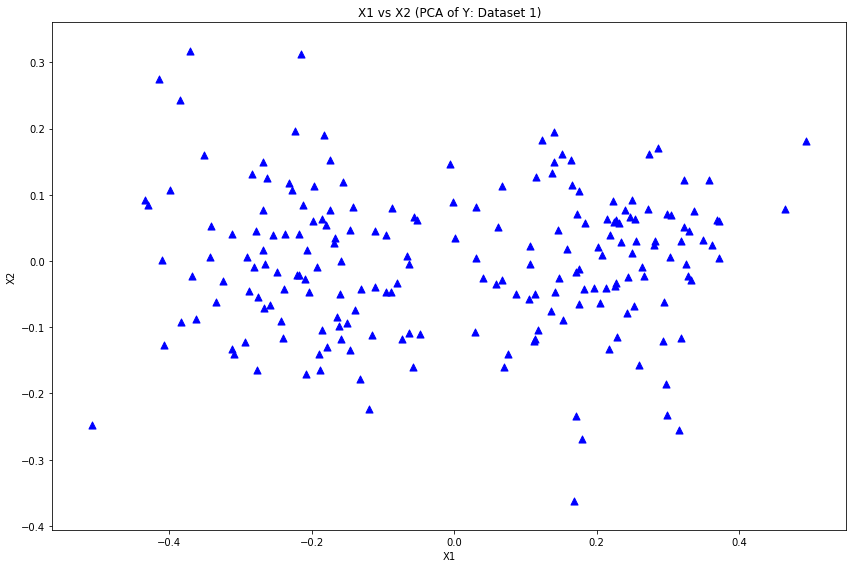

In [15]:
plot2D(list(X1_2d[0, :].flat), list(X1_2d[1, :].flat), 'X1 vs X2 (PCA of Y: Dataset 1)', 'X1', 'X2')

The data is concentrated in 2 spherical shapes. The PCA captures the 2 dimensions with most variance.<br>
And, looking at the PCA with these 2 spherical shapes, K=2 for KMeans seems to be a good value.

## Similarly, Kernel PCA with d=2

In [16]:
# Kernel Matrix
K = np.dot(Y_1.T, Y_1)
X1_k_2d = KPCA(K, 2)

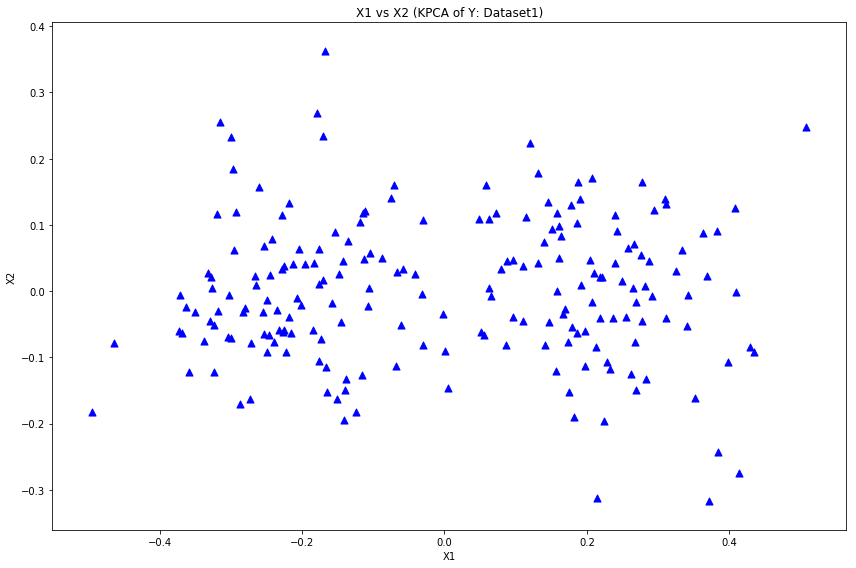

In [17]:
plot2D(list(X1_k_2d[0, :].real.flat), list(X1_k_2d[1, :].real.flat), 
       'X1 vs X2 (KPCA of Y: Dataset1)', 'X1', 'X2')

# K-means

## i) 40-dimensional data, Y_1 and plotting the first 2 dimensions

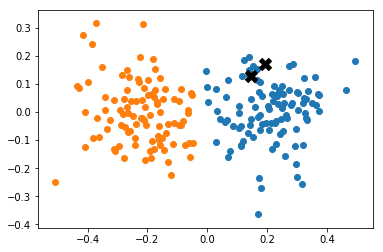

Iterations before Convergence: 3, with Total SSE: [37.06551573]


In [18]:
centroids, clustering, itr, err = kmeans(Y_1, 2, 5)
cluster_plot(centroids, X1_2d, clustering)

print("Iterations before Convergence: {}, with Total SSE: {}".format(itr, err))

For K=2 from the PCA plot, it does seems to be a good clustering with a 40-dimesnsional dataset. As the KMeans directly works on the actual data, it actually find out the actual centroids in 40D and plotting the 2-dimensional data captures those 2 clusters.

## ii) 2-dimensional data, X_2d (2-D data after PCA on Y)

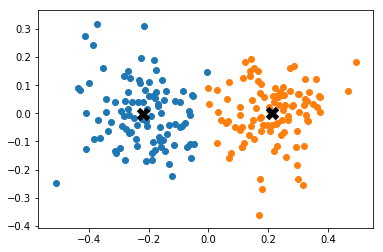

Iterations before Convergence: 1, with Total SSE: [26.13189158]
Final Centroids:
[matrix([[-0.22010542],
        [-0.00105522]]),
 matrix([[0.21147383],
        [0.00101384]])]


In [19]:
centroids, clustering, itr, err = kmeans(X1_2d, 2, 10)
cluster_plot(centroids, X1_2d, clustering)
print("Iterations before Convergence: {}, with Total SSE: {}".format(itr, err))
print("Final Centroids:")
pprint(centroids)

KMeans runs very well even on the PCA data of 40D, as the PCA captures the dimensions with most variance, it helps KMeans to cluster that data easily.

**Comments**

K-Means on both 40D and 2D (after PCA) produces similar results. PCA does a very good in preserving most of the variance in 2-dimensions. Thus, the K-Means captures the true clusters almost as they are. <br>
Since, PCA reduces the number of dimensions significantly, applying K-Means after PCA saves a lot of computational cost. Running KMeans on the low-dimensional representative data given by PCA will be fast as there will be much much lower calculations involved.

# Gaussian Kernel

In [20]:
def Gaussian(x, z, variance):
    return np.exp((-(np.linalg.norm(x - z) ** 2)) / (2 * variance))

def GaussianKernel(X, variance):
    # No of data points
    length = X.shape[1]
    
    # Kernel initialization
    K = np.zeros((length, length))
    
    for i in range(length):
        for j in range(length):
            K[i][j] = Gaussian(X[:, i], X[:, j], variance)
    return K

## Analysing some features of a 40-dimensional space, Y (dataset2)

### i) 1st and 2nd features

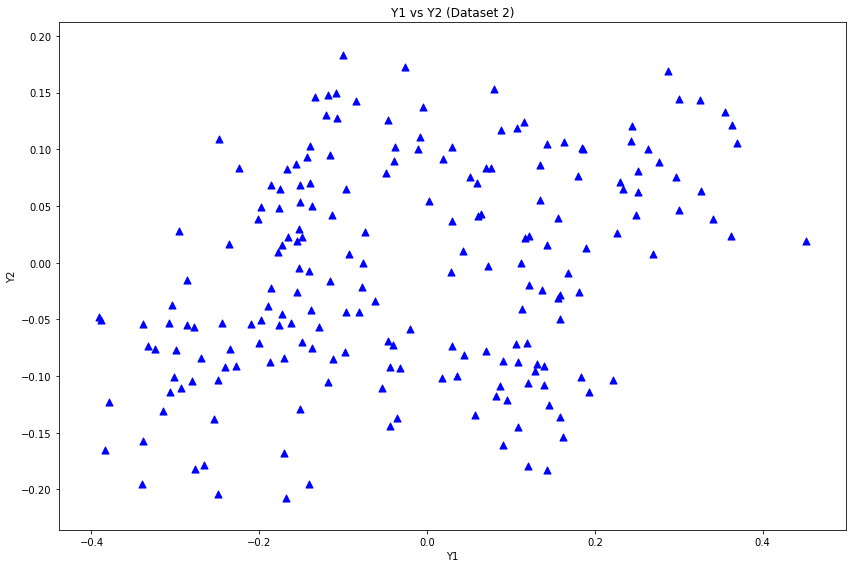

In [21]:
plot2D(list(Y_2[0, :].flat), list(Y_2[1, :].flat), 'Y1 vs Y2 (Dataset 2)', 'Y1', 'Y2')

Doesn't seems to have any structure among the first and second features.

### ii) 2nd and 3rd features

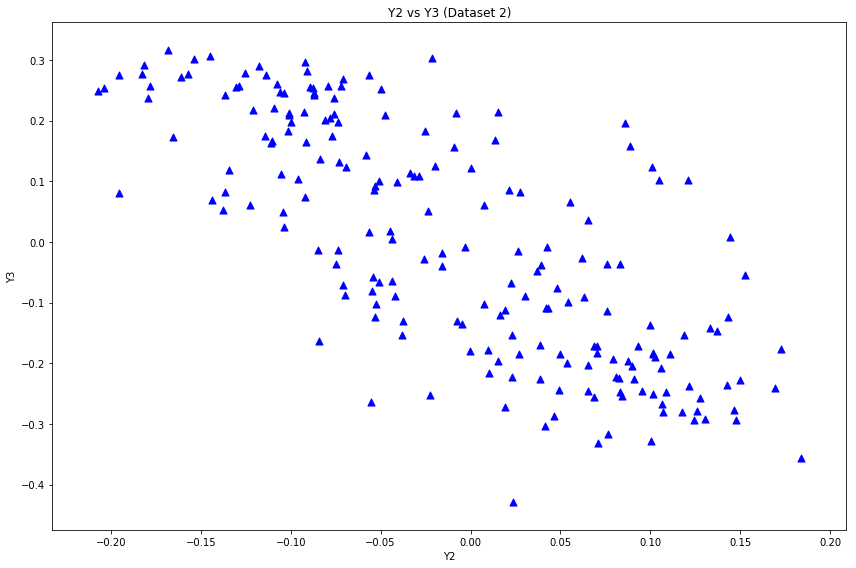

In [22]:
plot2D(list(Y_2[1, :].flat), list(Y_2[2, :].flat), 'Y2 vs Y3 (Dataset 2)', 'Y2', 'Y3')

Doesn't seem any solid structure among the second and third features. They might be just negatively correlated.

## PCA on dataset2 for low dimension, d=2

In [23]:
U_2d, mu, X2_2d = PCA(Y_2, Y_2.shape[1], 2)

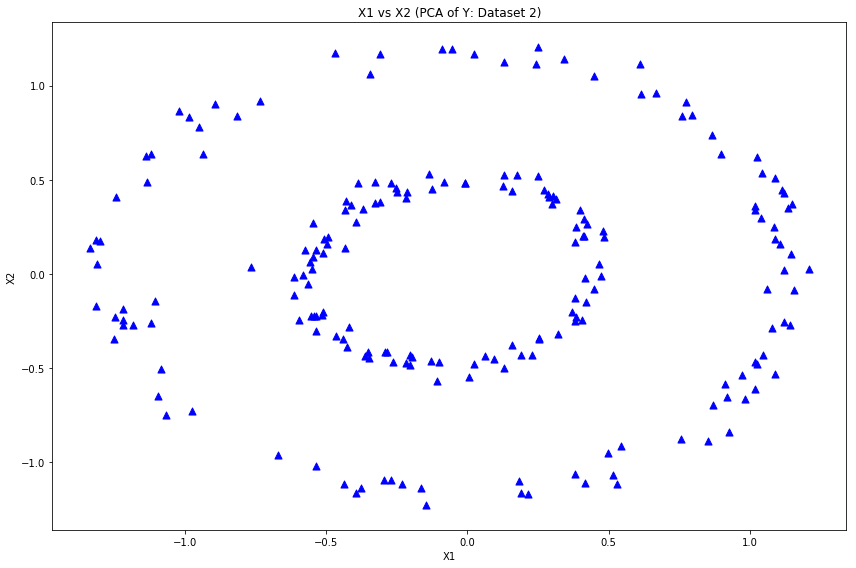

In [24]:
plot2D(list(X2_2d[0, :].flat), list(X2_2d[1, :].flat), 'X1 vs X2 (PCA of Y: Dataset 2)', 'X1', 'X2')

The 2-D PCA output structures as two concentric ellipses. <br>
Moreover, it implies that K=2 for clustering is a good choice for the given data.

In [25]:
np.var(X2_2d)

0.4212303437351286

## K-means on 2-dimensional data, X2_2d (PCA)

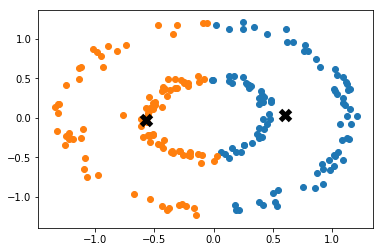

Iterations before Convergence: 7, with Total SSE: [126.68648332]
Final Centroids:
[matrix([[0.59764412],
        [0.03123693]]),
 matrix([[-0.5742071 ],
        [-0.03001195]])]


In [26]:
centroids, clustering, itr, err = kmeans(X2_2d, 2, 10)
cluster_plot(centroids, X2_2d, clustering)
print("Iterations before Convergence: {}, with Total SSE: {}".format(itr, err))
print("Final Centroids:")
pprint(centroids)

KMeans is good in finding spherical shape clusters where the density of each cluster is almost same. Here, KMeans divided the structure into 2 symmetrical parts which is actually not the real clustering of the data.

## Gaussian KPCA on dataset2

In [27]:
GK = GaussianKernel(Y_2, 0.216)
GK.shape

(200, 200)

In [28]:
X2_GK_2d = KPCA(GK, 2)

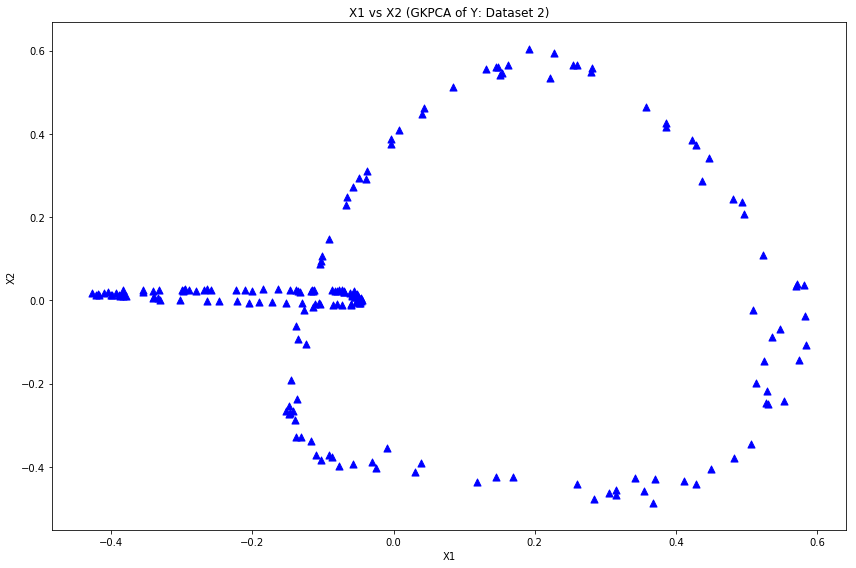

In [29]:
plot2D(list(X2_GK_2d[0, :].real.flat), list(X2_GK_2d[1, :].real.flat), 
       'X1 vs X2 (GKPCA of Y: Dataset 2)', 'X1', 'X2')

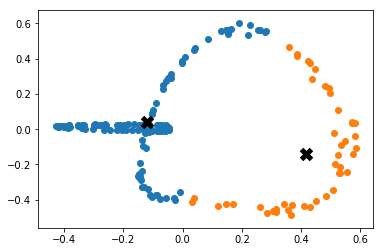

Iterations before Convergence: 13, with Total SSE: [46.30666857]
Final Centroids:
[matrix([[-0.12123102],
        [ 0.04104307]]),
 matrix([[ 0.41757352],
        [-0.14137057]])]


In [30]:
centroids, clustering, itr, err = kmeans(X2_GK_2d, 2, 10)
cluster_plot(centroids, X2_GK_2d, clustering)
print("Iterations before Convergence: {}, with Total SSE: {}".format(itr, err))
print("Final Centroids:")
pprint(centroids)

Gaussian Kernel PCA is an improvement over basic PCA. The complex Kernel tries to separate out the 2 concentric circles and does a job a fair job. <br>
Though even with the above parameters, Gaussian Kernel didn't truly extract the true clusters.

# Spectral Clustering (Dimensionality Reduction, then Clustering)

In [31]:
def computeWeight(X, KNN, variance):
    """ computes the Weight matrix, W"""
    neigh = NearestNeighbors(n_neighbors=KNN)
    neighbors = neigh.fit(X)
    # get indices of closet 'KNN' neighbors to X
    # the closest one at index 0 will be itself
    _, indices = neighbors.kneighbors(X)
    
    length = X.shape[0]
    W = np.zeros((length, length))
    
    # for each data point
    for index in indices:
        current_index = index[0]
        current_point = X[current_index]
        
        # for all closest neighbors starting from 1 (excluding itself)
        for j in range(1, len(index)):
            neighbor_index = index[j]
            neighbor = X[neighbor_index]
            gaussian_dist = Gaussian(current_point, neighbor, variance)
            W[current_index][neighbor_index] = gaussian_dist
            W[neighbor_index][current_index] = gaussian_dist
    return W

In [32]:
def spectralClustering(W, kclusters):
    """ Performs k-means on data reduced to 2-D through Spectral. """
    
    D = np.diag(np.sum(W, axis=0))
    L = D-W
    # Eigendecomposition of L
    lam, w = np.linalg.eig(L)
    
    # Sorting Eigenvalues
    val = np.argsort(lam)
    
    # Picking top K eigenvalues' index
    val = val[:kclusters]
    
    # The two corresponding EigenVectors
    w_new = w[:, [val[0],val[1]]]
    
    # runs k-means on the low-dimesional data, w_new
    centroids, clustering, _, _ = kmeans(w_new.T, kclusters, 5)
    return centroids, clustering

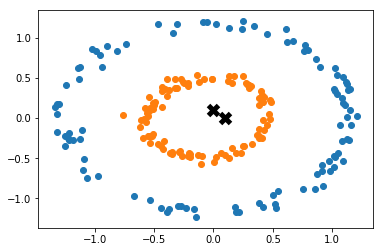

In [34]:
W = computeWeight(Y_2.T, KNN=5, variance=0.4)
centroids, clustering = spectralClustering(W, kclusters=2)
cluster_plot(centroids, X2_2d, clustering)

Spectral Clustering performs the best clustering so far with clear separation of two cocentric ellipses into two clusters. Hence recovers the true clustering. <br>
As the spectral clustering forms graphs with nodes connected to the KNN, the two  ellipses connects to the points in their own ellipse. Thus, in a way it separates out the two ellipses into two true clusters.